In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import os
os.environ['PYVIRTUALDISPLAY_DISPLAYFD'] = '0'


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


2024-04-07 16:01:03.000209: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 16:01:03.151950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 16:01:03.151982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 16:01:03.154801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 16:01:03.174187: I tensorflow/core/platform/cpu_feature_guar

In [3]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default


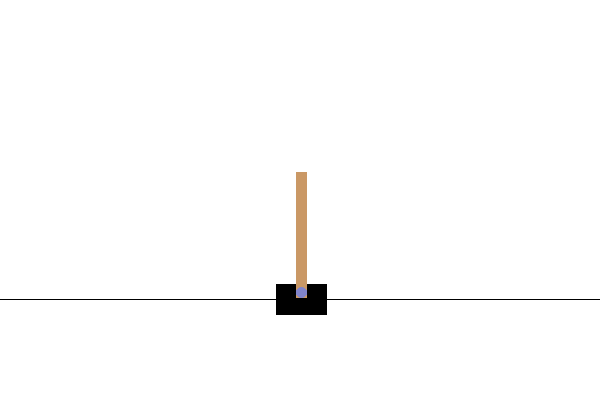

In [4]:
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())


In [5]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())


Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [6]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)


Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.03023775, -0.00193549,  0.02811389,  0.01024478], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.03019904,  0.19277222,  0.02831879, -0.27343696], dtype=float32)})


In [7]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [8]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()


2024-04-07 16:03:12.273293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 16:03:12.400136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 16:03:12.400199: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 16:03:12.405450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 16:03:12.405506: I external/local_xla/xla/stream_executor

In [10]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy


In [11]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# Please also see the metrics module for standard implementations of different
# metrics.


In [12]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      tf_agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    table_name=table_name,
    sequence_length=None,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpj8js4vq6.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpj8js4vq6
[reverb/cc/platform/default/server.cc:71] Started replay server on port 42469


In [13]:
def collect_episode(environment, policy, num_episodes):

  driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(
      policy, use_tf_function=True),
    [rb_observer],
    max_episodes=num_episodes)
  initial_time_step = environment.reset()
  driver.run(initial_time_step)


In [14]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_py_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Use data from the buffer and update the agent's network.
  iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
  trajectories, _ = next(iterator)
  train_loss = tf_agent.train(experience=trajectories)

  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (424795) so Table uniform_table is accessed directly without gRPC.
2024-04-07 16:04:11.419148: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc088e26230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 16:04:11.419193: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-07 16:04:11.437383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-07 16:04:11.472095: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1712486051.588225  425636 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[reverb/cc/client.cc:165] Sampler and serve

step = 25: loss = 0.3801760673522949


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (424795) so Table uniform_table is accessed directly without gRPC.


step = 50: loss = 1.767978549003601
step = 50: Average Return = 74.69999694824219


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (424795) so Table uniform_table is accessed directly without gRPC.


step = 75: loss = 1.339118480682373
step = 100: loss = 1.6975359916687012
step = 100: Average Return = 91.69999694824219
step = 125: loss = 1.239509105682373


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (424795) so Table uniform_table is accessed directly without gRPC.


step = 150: loss = 1.4495882987976074
step = 150: Average Return = 145.3000030517578
step = 175: loss = 1.789027214050293
step = 200: loss = 4.641960144042969
step = 200: Average Return = 189.89999389648438
step = 225: loss = -4.131172180175781
step = 250: loss = 0.2894554138183594
step = 250: Average Return = 198.39999389648438


(68.4349967956543, 250.0)

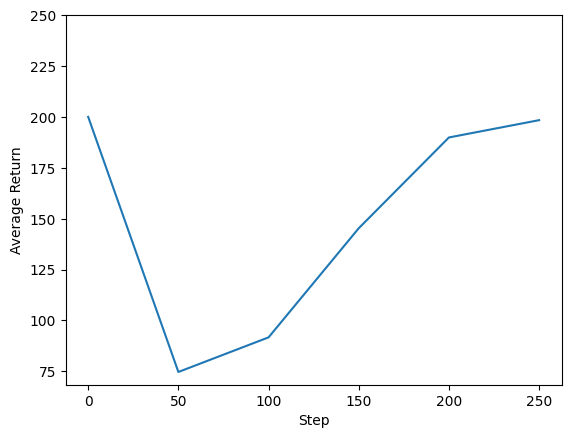

In [15]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)


In [16]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)


In [17]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)


[swscaler @ 0x56473ee925c0] Warning: data is not aligned! This can lead to a speed loss
